In [1]:
import numpy as np
import pennylane as qml
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
IBMQ.save_account('7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1')
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2023-03-12 13:07:48,148: Credentials already present. Set overwrite=True to overwrite.


In [12]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

In [13]:
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit.opflow import TwoQubitReduction

In [14]:
from qiskit_nature.second_q.circuit.library import  HartreeFock
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.circuit import Parameter
from qiskit.opflow import Suzuki, PauliTrotterEvolution


In [15]:
from qiskit.primitives import Estimator
import time
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

Noiseless Simulations

In [16]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x], shots=1024 )
            
            # Get results from jobs
            est_result = job.result()
            
            # Get the measured energy value
            value = est_result.values[0]
            
            
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [20]:
def Energ_calc(r, theta):
    

    # Define Molecule
    bl = 1.16
    
    molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["Cu", [0,0,0]],
        ["O", [r*np.cos(theta),r*np.sin(theta),0]],
        ["C", [(r+1.16)*np.cos(theta),(r+1.16)*np.sin(theta),0]],
        ["O", [(r+2*1.16)*np.cos(theta),(r+2*1.16)*np.sin(theta),0]],
        ['N', [0.854*0.52917721067121, 0, 0]],
        ['N', [0.854*0.52917721067121+1.09, 0, 0]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=1,
)
    
    driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="cc-pVDZ",
    driver_type=ElectronicStructureDriverType.PYSCF)

    problem = ElectronicStructureProblem(
    driver,
    [ActiveSpaceTransformer(4,4)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    mapper = ParityMapper()
    converter = QubitConverter(mapper, two_qubit_reduction=True)
    hamiltonian = second_q_ops['ElectronicEnergy']
    qubit_op = converter.convert(hamiltonian)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = reducer.convert(qubit_op)
    num_particles = num_particles
    num_spin_orbitals = num_spin_orbitals -2
    
    t_0 = Parameter('t_0')
    weights = [1,1]
    paulis = ['IYXZII', 'ZXYIII']
    pauli_op = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]

    h_aux = PauliSumOp.from_list([ op for op in pauli_op ])

    aux = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert((h_aux*t_0).exp_i())

    Ansatz = HartreeFock(num_spin_orbitals//2, num_particles, converter)

    Ansatz.append(aux, [i for i in range(num_spin_orbitals)])
     
    # Define instance of qiskit-terra's Estimator primitive
    estimator = Estimator([Ansatz], [qubit_op])
    # Setup VQE algorithm

    # Define a simple callback function
    intermediate_info = []
    def callback(value):
            intermediate_info.append(value)

    custom_vqe = CustomVQE(estimator, Ansatz, optimizer, callback=callback)

    # Run the custom VQE function and monitor execution time
    
    res_sim = custom_vqe.compute_minimum_eigenvalue(qubit_op)
    
    
    cmp_gs = problem.interpret(res_sim).total_energies[0].real
    
    return cmp_gs *  27.211

In [23]:
theta_val =[i*np.pi/8 for i in range(1, 9)]
r_val = [i*0.15 for i in range(1, 10)]

print(theta_val)
print(r_val)

[0.39269908169872414, 0.7853981633974483, 1.1780972450961724, 1.5707963267948966, 1.9634954084936207, 2.356194490192345, 2.748893571891069, 3.141592653589793]
[0.15, 0.3, 0.44999999999999996, 0.6, 0.75, 0.8999999999999999, 1.05, 1.2, 1.3499999999999999]


In [24]:
X = []
Y = []
Z = []
optimizer = COBYLA(100)
start = time.time()
for theta in theta_val:
    for r in r_val:
        X.append(theta)
        Y.append(r)
        Z.append(Energ_calc(r, theta))
        print(Z[-1])
    
end = time.time()
print(f'execution time (s): {end - start:.2f}')

-42979.64170486428
-48596.54602205806
-49424.167431432994
-50736.885771864465
-51451.001034869434
-51752.823257876684
-51860.247551471635
-51885.45123770649
-51889.629936991245
-43211.92902624993
-49400.64771248517
-50833.13577233865
-51444.928191962405
-51729.10731214013
-51873.33873857638
-51946.74422635355
-51983.95693490189
-52003.21761768894
-43345.86687651452
-49704.821124225804
-51140.7494128807
-51633.53026116537
-51829.83808794352
-51926.09349413268
-51979.645132896876
-52008.28115271705
-52023.05892601181
-43425.68143651232
-49827.43091965189
-51224.16125617187
-51689.705532005326
-51867.410494007265
-51950.52917745011
-51995.385245074984
-52018.9284717793
-52030.612960622435
-43481.122946813586
-49880.22114864999
-51264.76398098759
-51714.49829495436
-51881.53233258245
-51957.38146579303
-51998.77706067826
-52020.78861640005
-52031.828135276075
-43517.15266969046
-49922.619712056345
-51286.32977061114
-51722.52495904838
-51883.3848513615
-51956.76576080622
-51997.98812617807

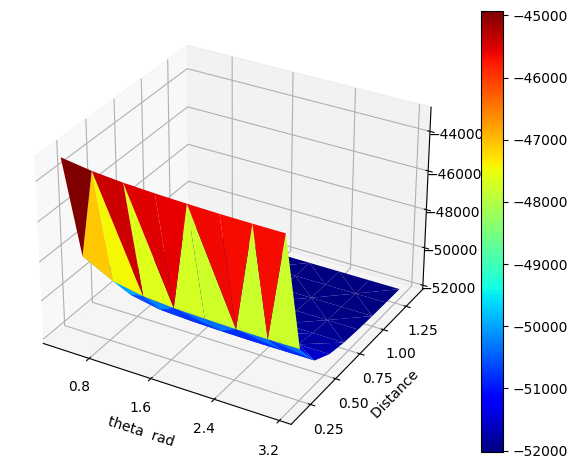

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import MaxNLocator


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(X, Y, Z, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))

#ax.set_zlabel('Energy eV')
ax.set_ylabel(r'Distance ')
ax.set_xlabel('theta  rad')

fig.tight_layout()
plt.savefig('CO2_N2.png')
plt.show()

In [54]:
for x in Z:
    print(x)

-42979.64170486428
-48596.54602205806
-49424.167431432994
-50736.885771864465
-51451.001034869434
-51752.823257876684
-51860.247551471635
-51885.45123770649
-51889.629936991245
-43211.92902624993
-49400.64771248517
-50833.13577233865
-51444.928191962405
-51729.10731214013
-51873.33873857638
-51946.74422635355
-51983.95693490189
-52003.21761768894
-43345.86687651452
-49704.821124225804
-51140.7494128807
-51633.53026116537
-51829.83808794352
-51926.09349413268
-51979.645132896876
-52008.28115271705
-52023.05892601181
-43425.68143651232
-49827.43091965189
-51224.16125617187
-51689.705532005326
-51867.410494007265
-51950.52917745011
-51995.385245074984
-52018.9284717793
-52030.612960622435
-43481.122946813586
-49880.22114864999
-51264.76398098759
-51714.49829495436
-51881.53233258245
-51957.38146579303
-51998.77706067826
-52020.78861640005
-52031.828135276075
-43517.15266969046
-49922.619712056345
-51286.32977061114
-51722.52495904838
-51883.3848513615
-51956.76576080622
-51997.98812617807